In [1]:
import os
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats


import sys
sys.path.insert(0, '..')
from src.data import TimeSeries

In [56]:
pd.options.mode.chained_assignment = None
IMAGE_DIR = '/home/dalton/projects/practicum/deliverables/latex/assets/test/'

data = {
    'blood-refrigerator':{'date': '2022-12-26'},
    'nitrogen-generator':{'date': '2023-09-29'}
}

for dir in os.listdir('../data'):
    if dir == 'wrapper-machine':
        continue

    # Data loading
    data_dir_path = os.path.join('../data', dir)
    if dir == 'nitrogen-generator':
        tf = '%Y-%m-%d %H:%M:%S'
    else:
        tf = '%Y-%m-%d %H:%M:%S.%f'

    train_ts = TimeSeries.from_csv(
        'pandas',
        os.path.join(data_dir_path, 'train.csv')
    )
    valid_ts = TimeSeries.from_csv(
        'pandas',
        os.path.join(data_dir_path, 'val.csv')
    )
    test_ts = TimeSeries.from_csv(
        'pandas',
        os.path.join(data_dir_path, 'test.csv')
    )

    # Data prep
    train_ts.parse_datetime('timestamp', tf)
    valid_ts.parse_datetime('timestamp', tf)
    test_ts.parse_datetime('timestamp', tf)

    train_ts.split_by_day()
    valid_ts.split_by_day()
    test_ts.split_by_day()

    temp = pd.concat(
        train_ts.time_series[k].drop(
            columns=['timestamp','PW_0.5h','date','time']
        ) for k in train_ts.time_series.keys()
    )

    FEATURE_COLS = [
        c for c in temp.columns if np.std(temp[c])!=0.0
    ]
    LABEL_COL = 'PW_0.5h'

    temp = None
    del temp

    data.update({dir: {
        'train': train_ts.data[['timestamp']+FEATURE_COLS+[LABEL_COL]],
        'valid': valid_ts.data[['timestamp']+FEATURE_COLS+[LABEL_COL]],
        'test':test_ts.data[['timestamp']+FEATURE_COLS+[LABEL_COL]],
        'feats': FEATURE_COLS,
        'label': LABEL_COL,
        'date': data[dir]['date']
    }})

blood-refrigerator
[]
nitrogen-generator
['Machine_cooling', 'Machine_defrost', 'Machine_pause']


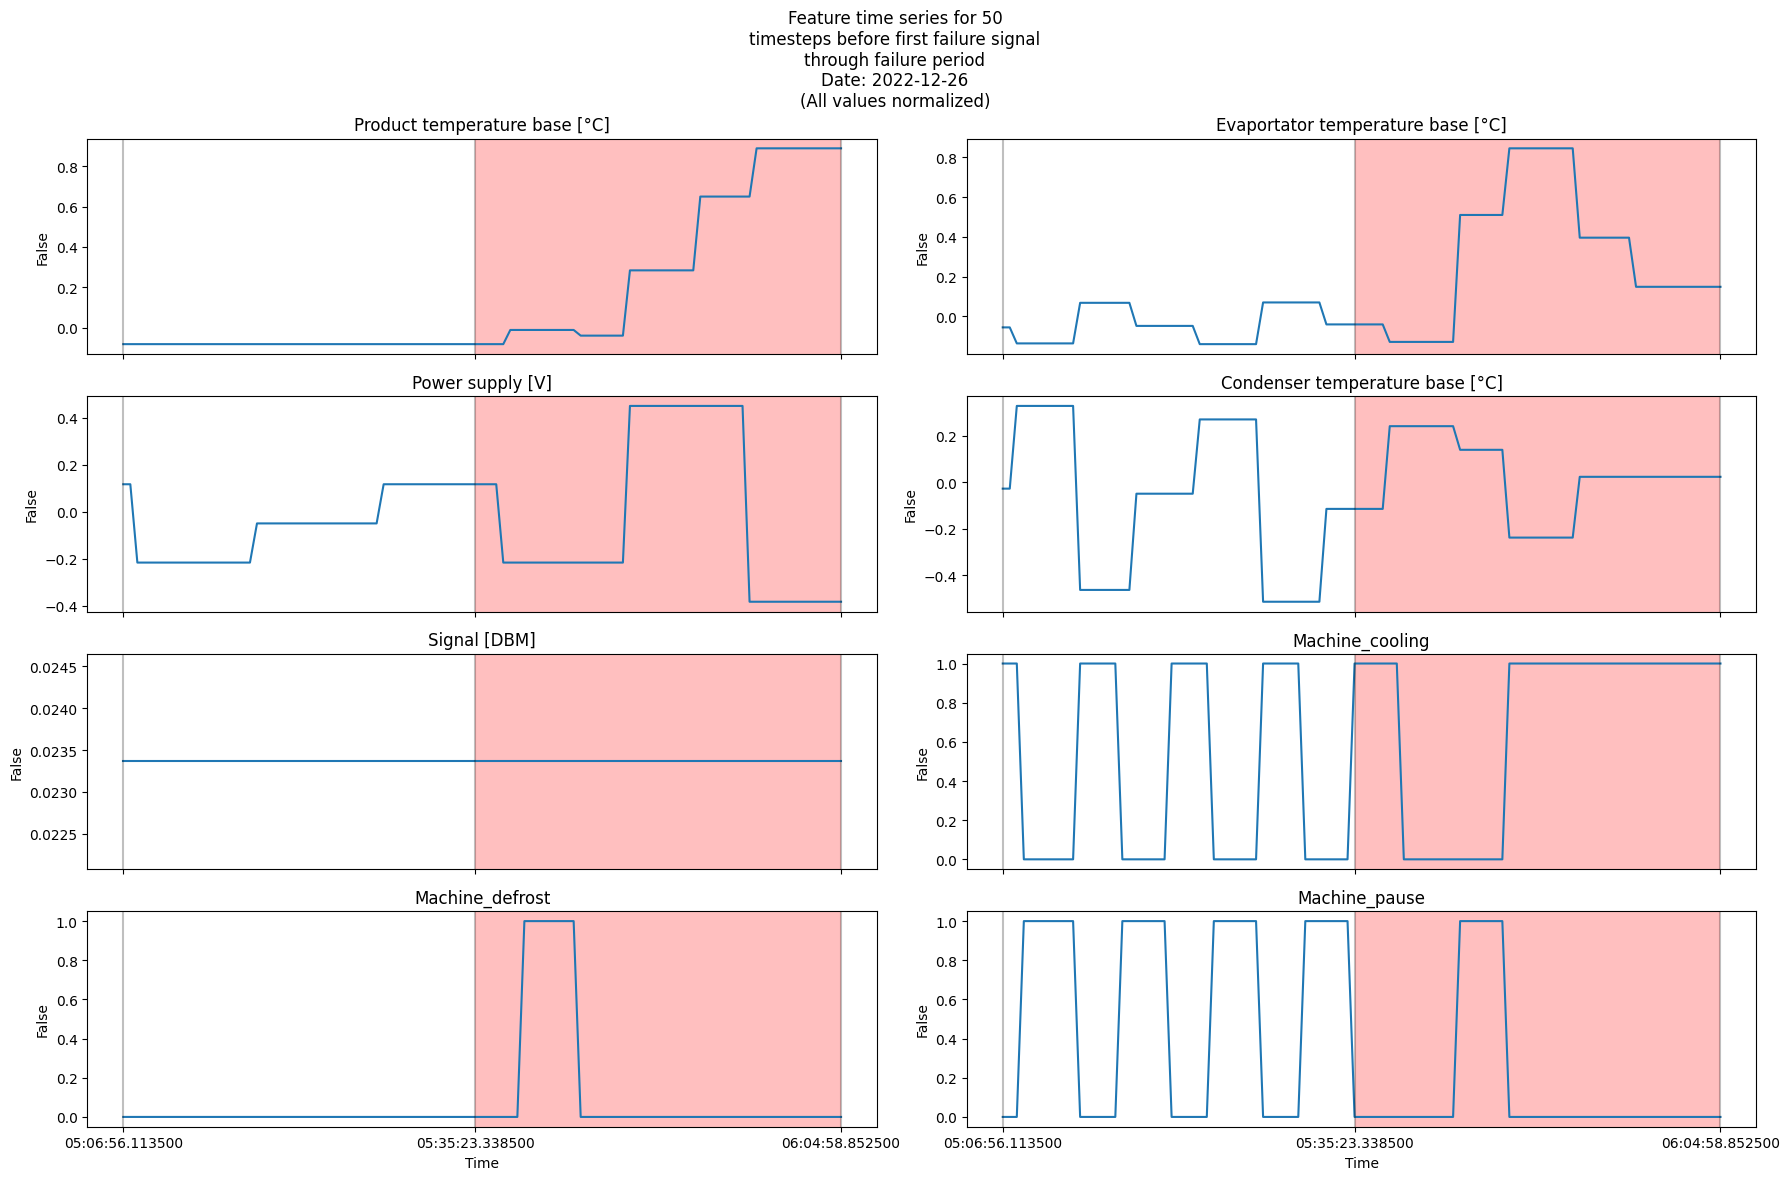

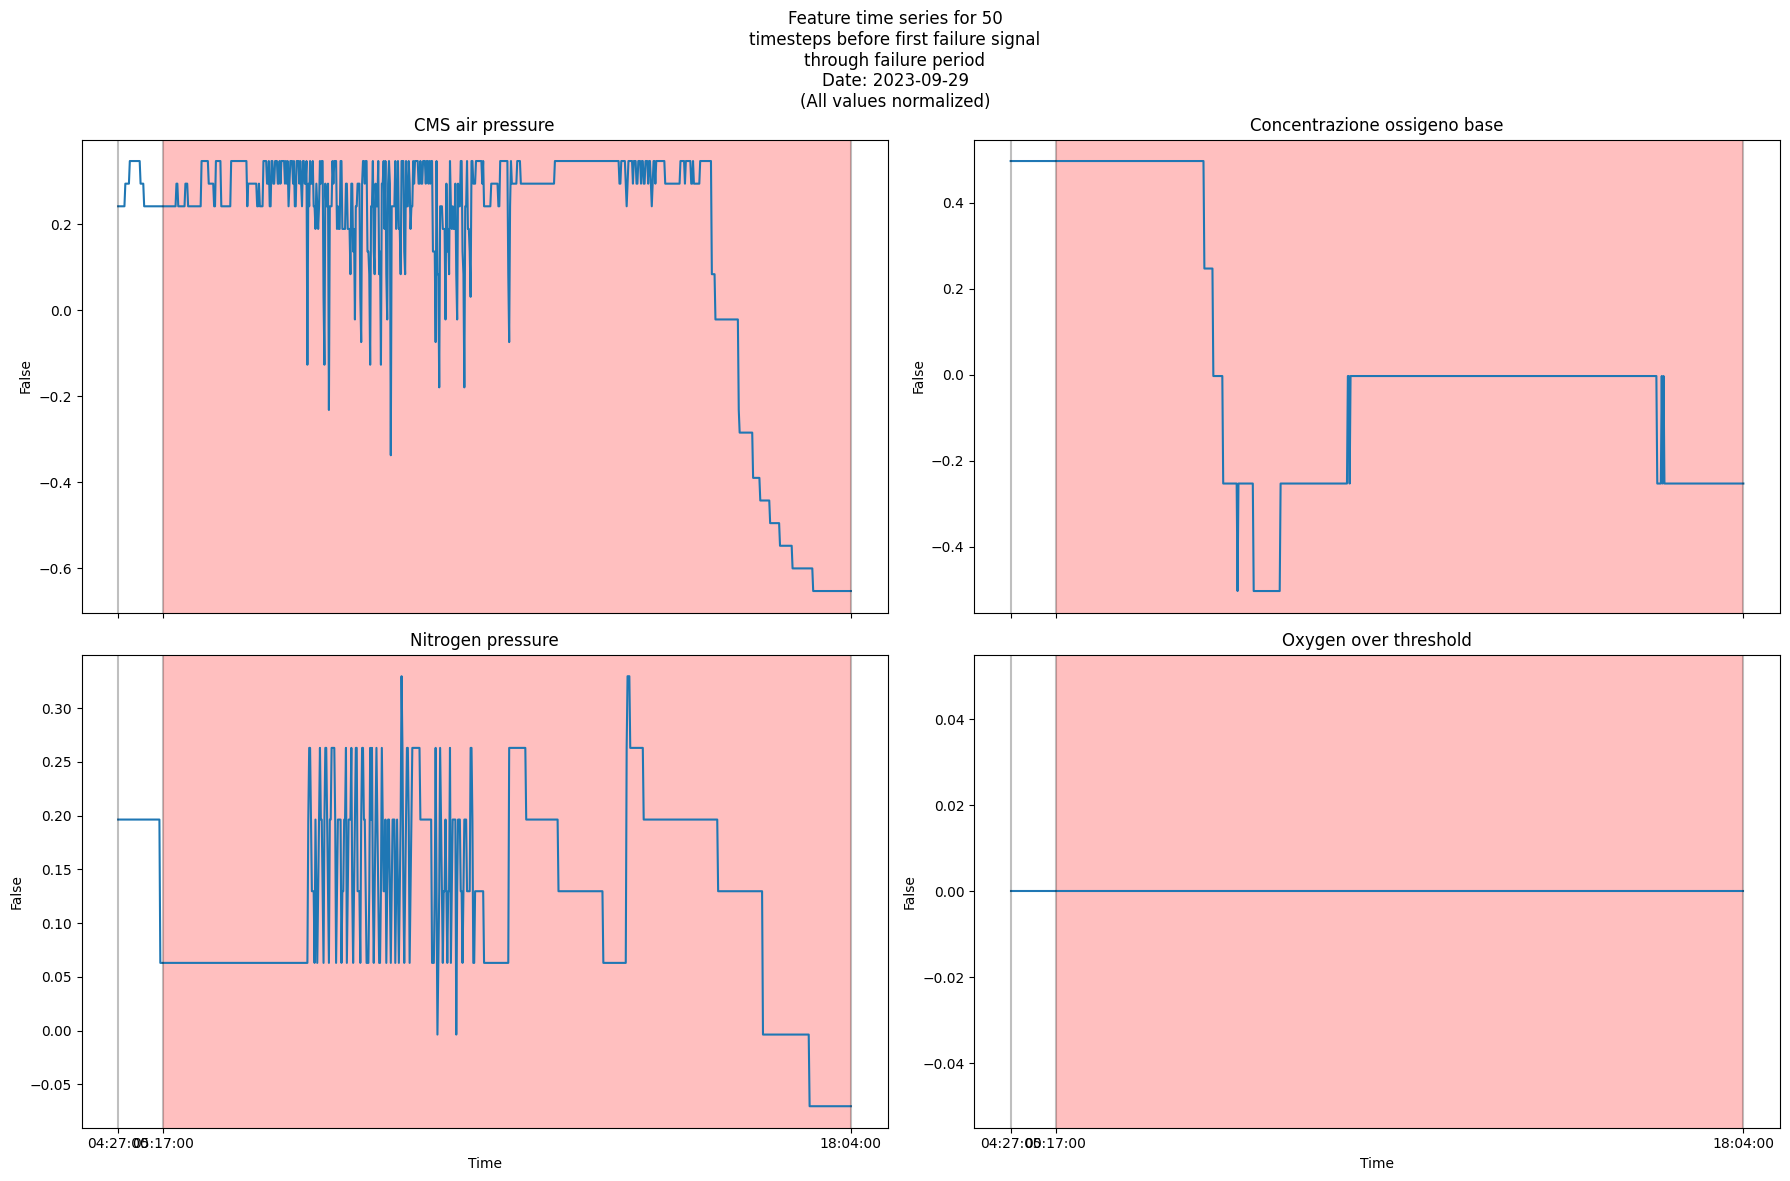

In [91]:
# Normal plot of all
subdata = {}

for nm, dset in data.items():
    print(nm)
    # Drop cols
    FEATURE_COLS = dset['feats']
    LABEL_COL = dset['label']
    DATE = dset['date']
    tmp = dset['test'][dset['test']['timestamp'].str.contains(DATE)]
    FEATURE_COLS = [
        c for c in FEATURE_COLS if tmp[c].std()!=0.0 
    ]
    X = tmp[FEATURE_COLS]  # DataFrame
    y = tmp[LABEL_COL]
    NONBINARY_FEATURE_COLS = [
            c for c in FEATURE_COLS if not (X[c].max()==1 and X[c].min()==0 )
        ]
    print(BINARY_FEATURE_COLS)
    BINARY_FEATURE_COLS = [c for c in FEATURE_COLS if c not in NONBINARY_FEATURE_COLS]
    binary_feats = X[[c for c in FEATURE_COLS if c not in NONBINARY_FEATURE_COLS]]
    # Normalize
    x_max = X[NONBINARY_FEATURE_COLS].max()
    x_min = X[NONBINARY_FEATURE_COLS].min()
    x_mean = X[NONBINARY_FEATURE_COLS].mean()

    X = (X[NONBINARY_FEATURE_COLS]-x_mean) / (x_max-x_min)
    X.loc[:,'tmp'] = tmp.loc[:,'timestamp'].apply(lambda x: x.split(' ')[-1])
    X.loc[:,BINARY_FEATURE_COLS] = binary_feats

    window_st = max(y[y==1].index[0]-50, 0)
    window_end = y[y==1].index[-1]
    
    X = X.loc[window_st:window_end]
    y = y.loc[window_st:window_end]

    X.index = X['tmp']
    X.drop(columns=['tmp'],inplace=True)

    # Plot series w/ failure regions
    nrows = (len(FEATURE_COLS) // 2)
    ncols = 2
    fig, axs = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        sharex=True,
        sharey=False,
        figsize=(18,12),
        layout='tight'
    )
    col_y = 0
    day = DATE.split(' ')[0]
    fig.suptitle(
        f'Feature time series for 50\ntimesteps before first failure signal\nthrough failure period\nDate: {DATE}\n(All values normalized)'
    )
    for i, col in enumerate(FEATURE_COLS):
        row_x = int(i/2)

        ts = X[col].replace([np.inf, -np.inf], np.nan).fillna(0)
        sns.lineplot(
            data=ts,
            ax=axs[row_x][col_y]
        )
        axs[row_x][col_y].set(
            xlabel='Time',
            title=col,
            ylabel=False
        )
        axs[row_x][col_y].set_xticks([ts.index[0], ts.index[50], ts.index[-1]])
        axs[row_x][col_y].axvline(ts.index[0], color='black', alpha=0.25)
        axs[row_x][col_y].axvline(ts.index[50], color='black', alpha=0.25)
        axs[row_x][col_y].axvline(ts.index[-1], color='black', alpha=0.25)
        axs[row_x][col_y].axvspan(
            50, len(ts)-1, facecolor='red', alpha=0.25
        )

        col_y = int(col_y!=1)

    plt.savefig(f'../deliverables/latex/assets/test/{nm}/features.png', dpi=500)

blood-refrigerator
nitrogen-generator


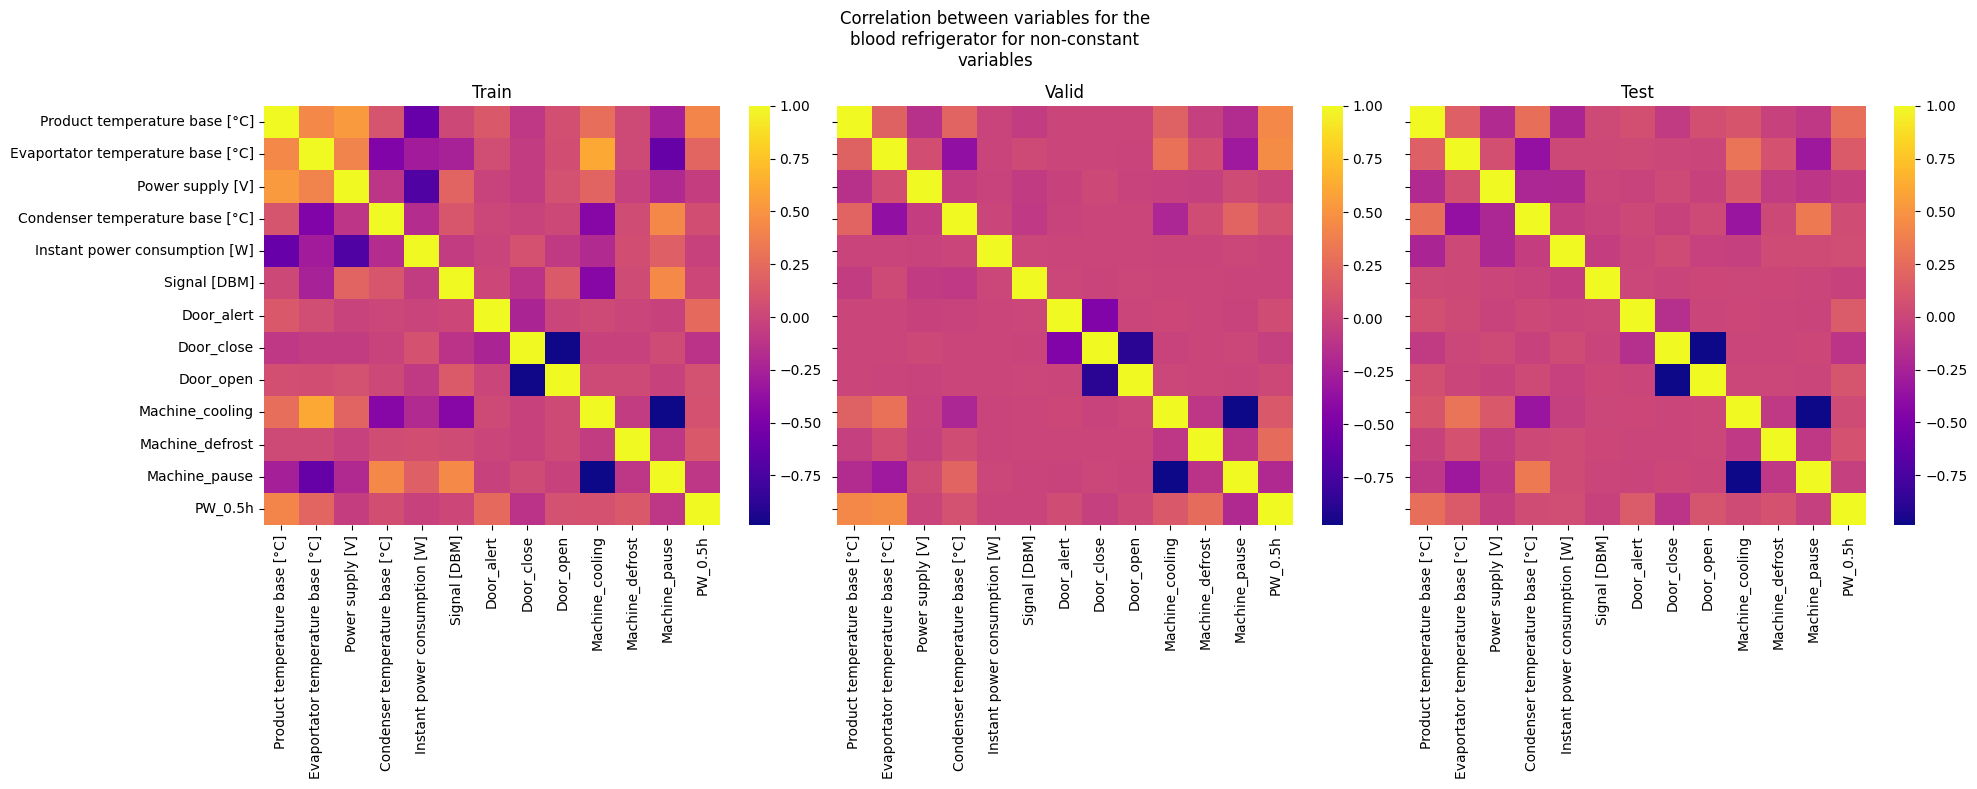

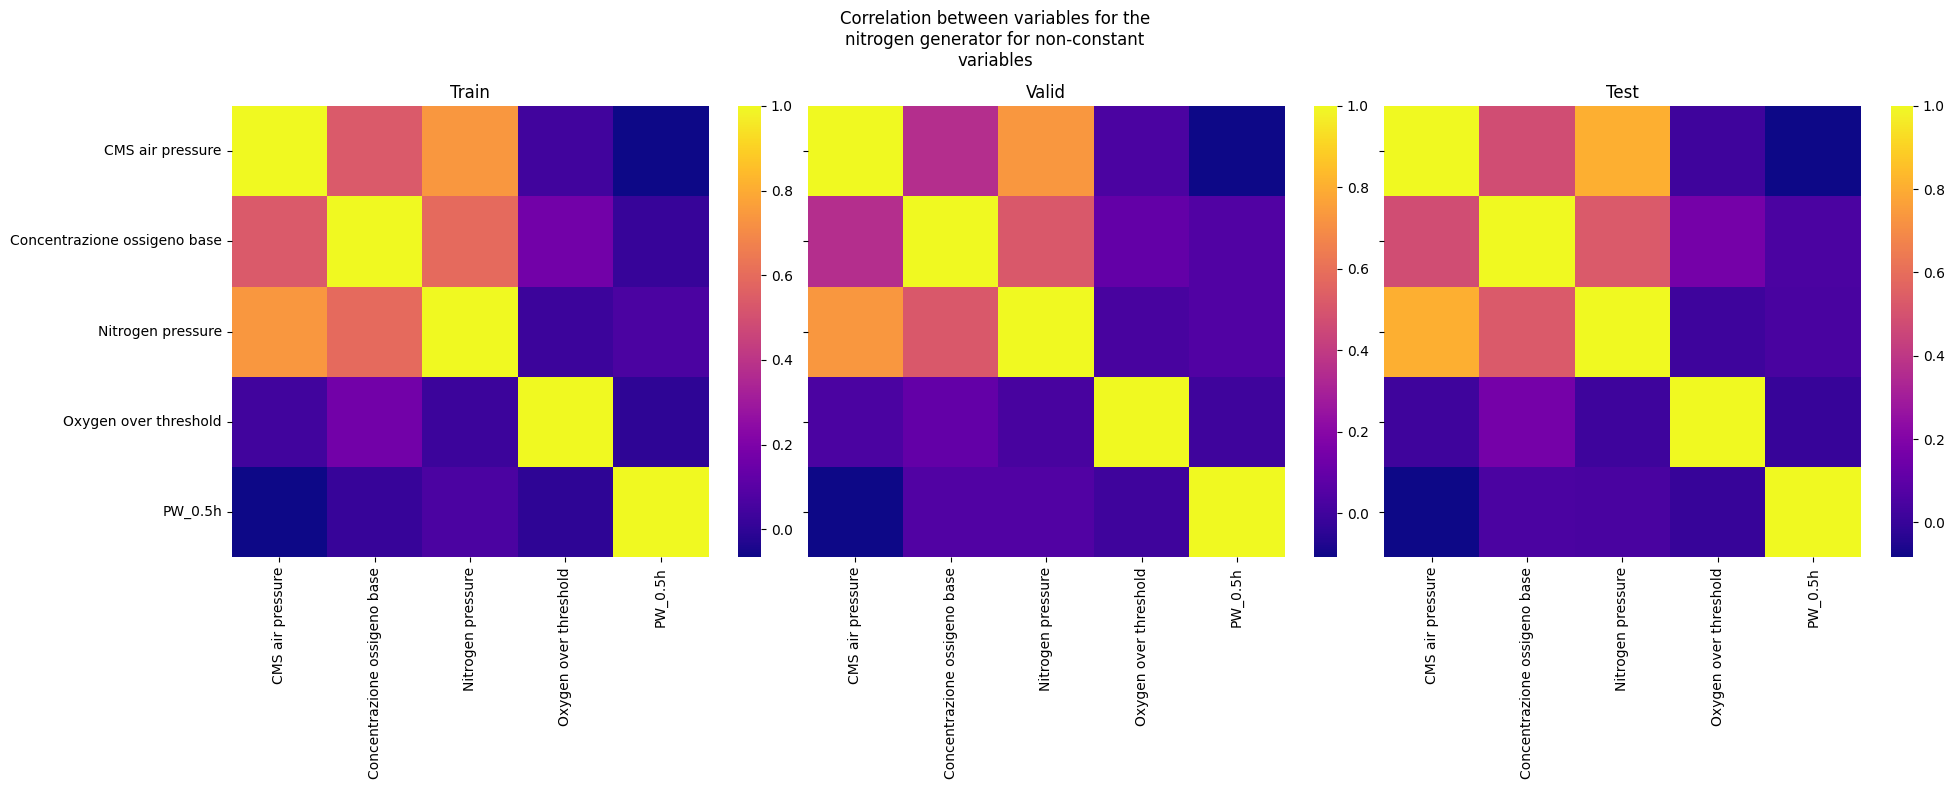

In [98]:
# Correlations
for nm, dset in data.items():
    print(nm)
    # Drop cols
    FEATURE_COLS = dset['feats']
    LABEL_COL = dset['label']

    fig, axs = plt.subplots(1,3,sharex=True,sharey=True,figsize=(20,8),layout='tight')

    for i, split in enumerate(['train','valid','test']):
        corr = dset[split][FEATURE_COLS+[LABEL_COL]].corr()
        sns.heatmap(
            corr,
            ax=axs[i],
            cmap='plasma'
        )
        axs[i].set(
            title=split.title()
        )

    fig.suptitle(
        'Correlation between variables for the\n'
        f'{nm.replace("-"," ")} for non-constant\n'
        'variables'
    )

    plt.savefig(f'../deliverables/latex/assets/test/{nm}/correlations.png', dpi=400)

# Auto correlations

blood-refrigerator


/tmp/ipykernel_128883/1767121767.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(NONBINARY_FEATURE_COLS, rotation=45, ha='right')
/tmp/ipykernel_128883/1767121767.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(NONBINARY_FEATURE_COLS, rotation=45, ha='right')
/tmp/ipykernel_128883/1767121767.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(NONBINARY_FEATURE_COLS, rotation=45, ha='right')


nitrogen-generator


/tmp/ipykernel_128883/1767121767.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(NONBINARY_FEATURE_COLS, rotation=45, ha='right')
/tmp/ipykernel_128883/1767121767.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(NONBINARY_FEATURE_COLS, rotation=45, ha='right')
/tmp/ipykernel_128883/1767121767.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(NONBINARY_FEATURE_COLS, rotation=45, ha='right')


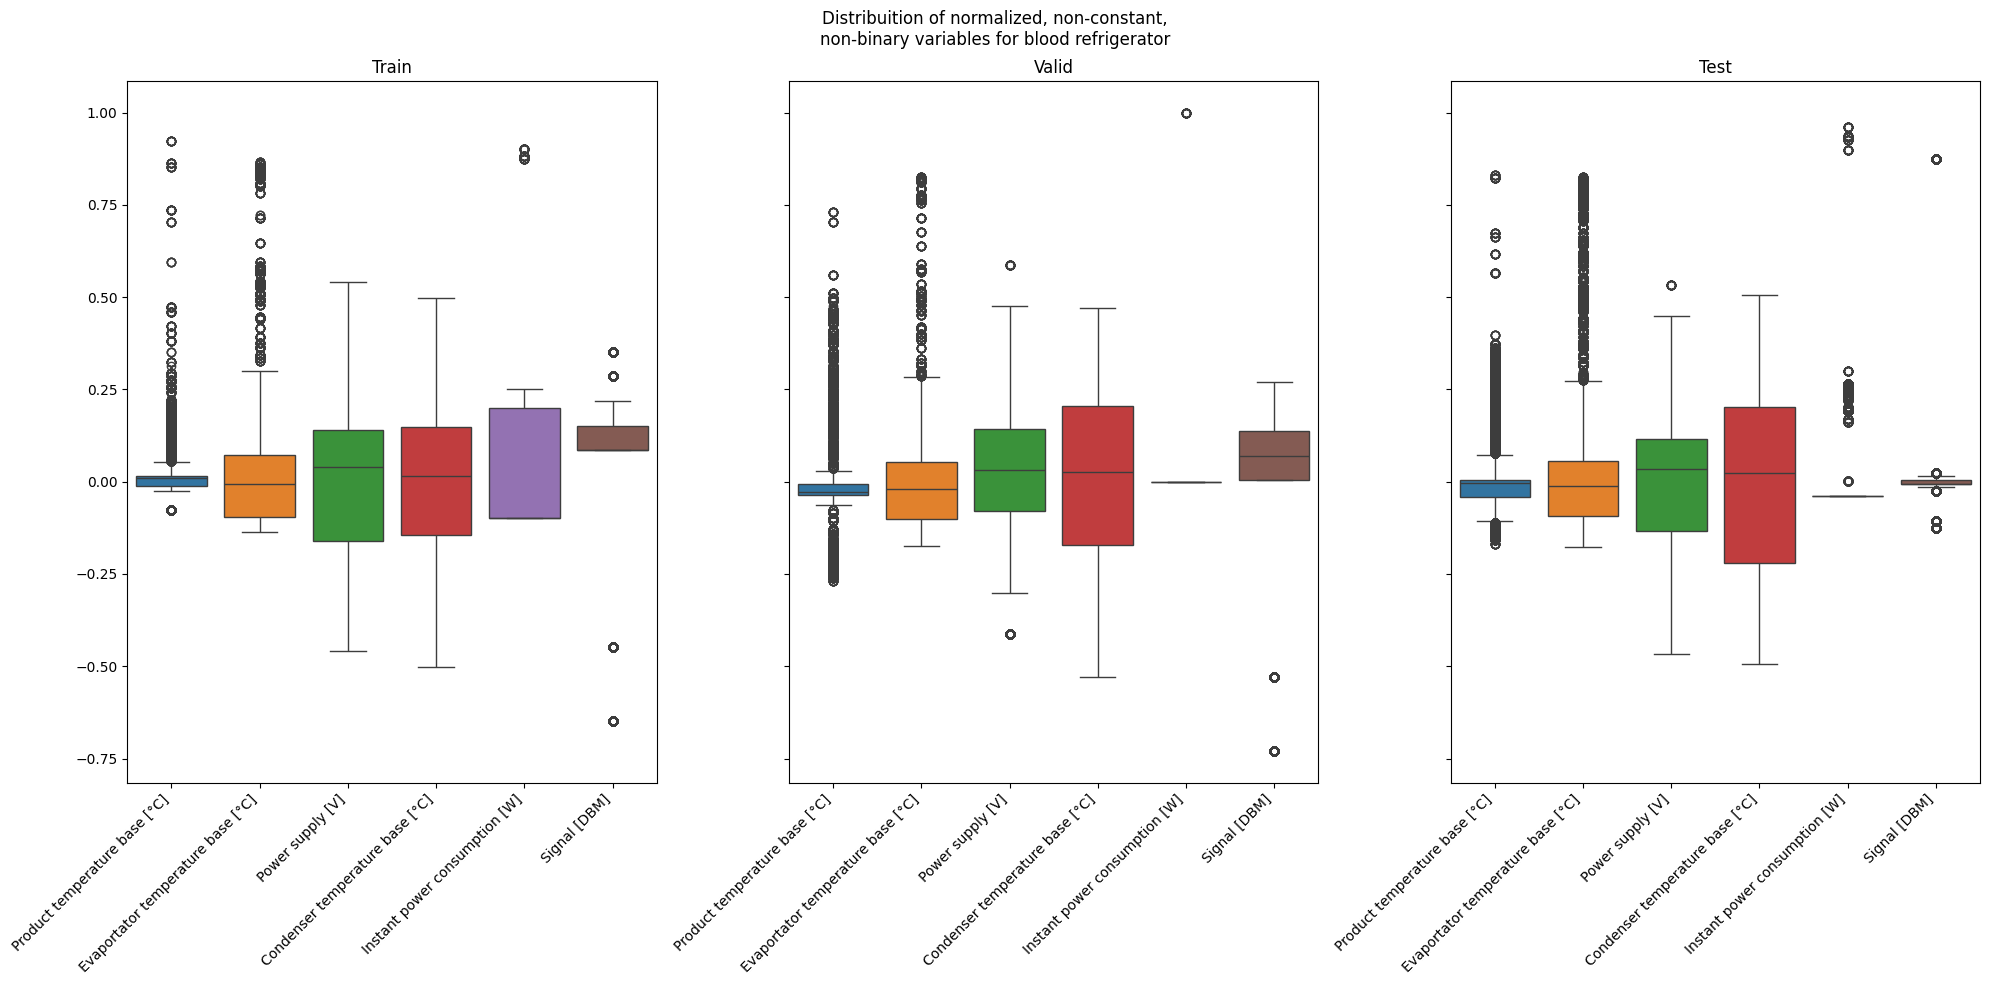

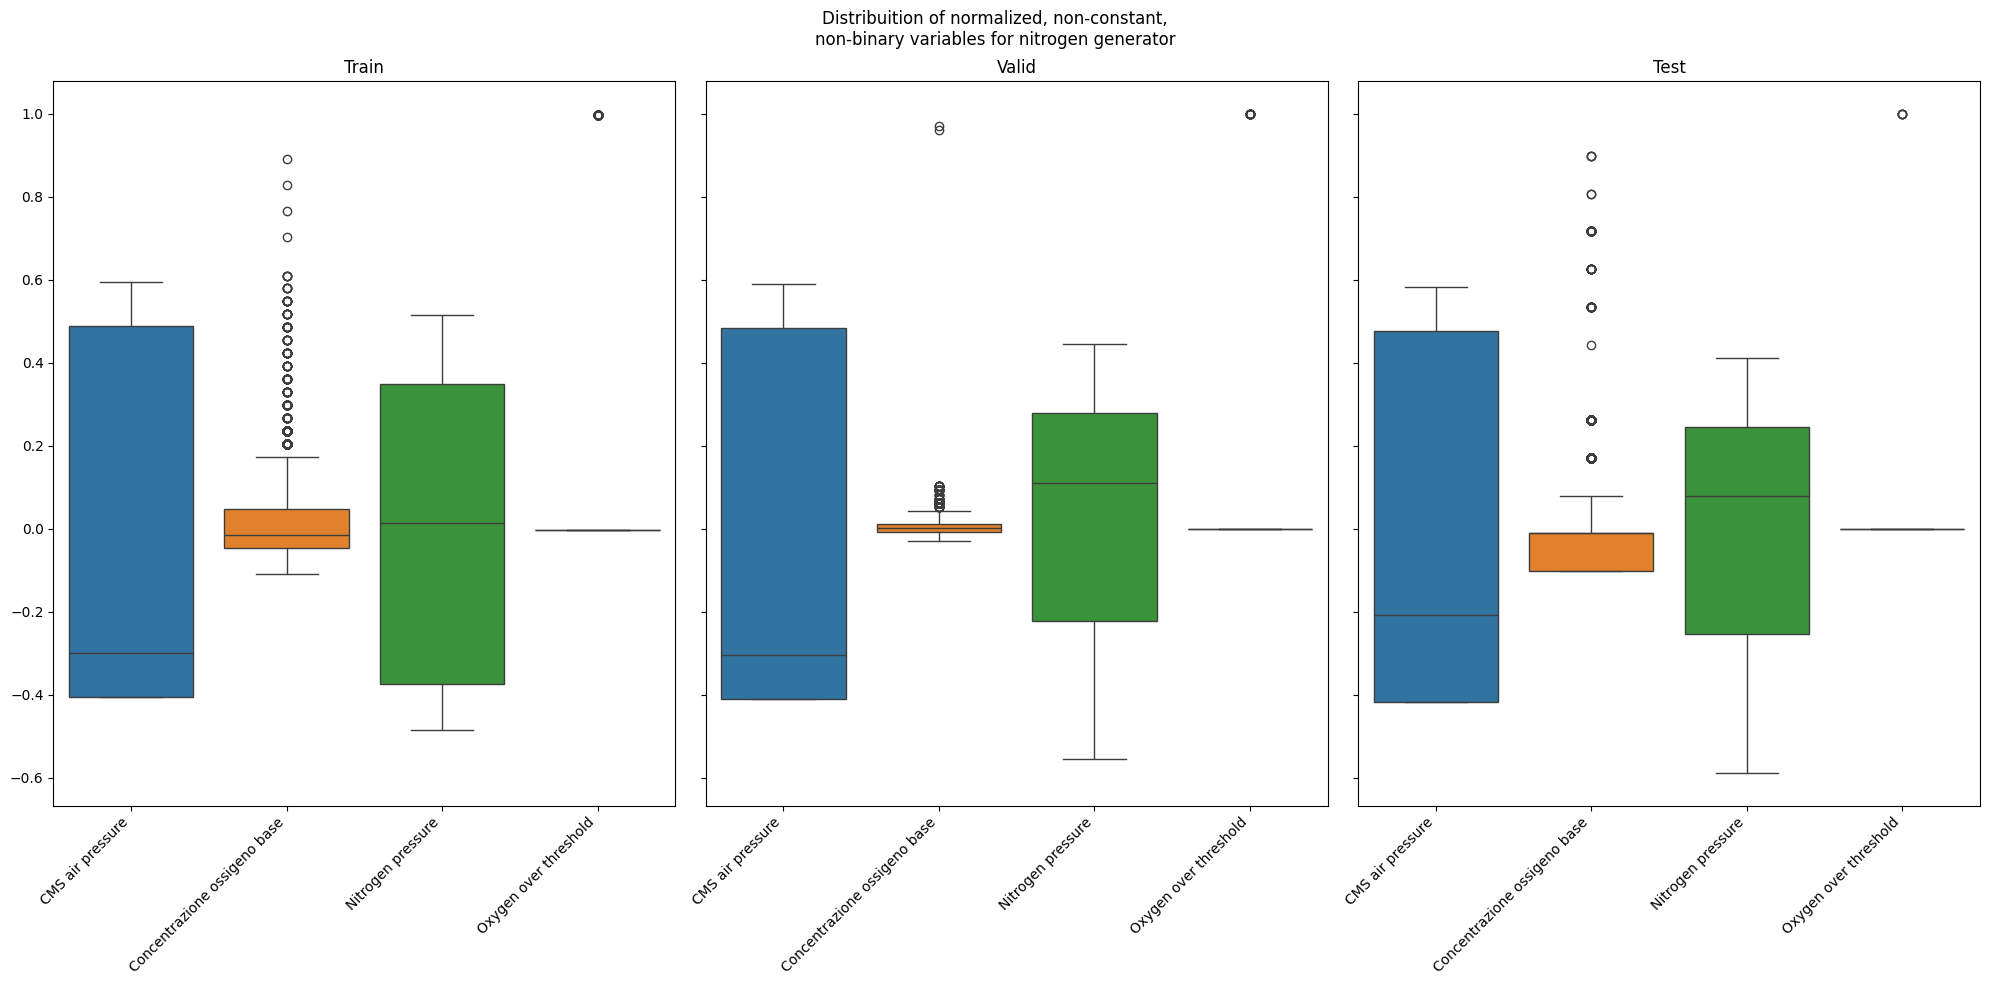

In [97]:
# Summary stats
for nm, dset in data.items():
    print(nm)
    # Drop cols
    FEATURE_COLS = dset['feats']
    
    LABEL_COL = dset['label']

    fig, axs = plt.subplots(1,3,sharex=True,sharey=True,figsize=(20,10),layout='tight')

    for i, split in enumerate(['train','valid','test']):
        X = dset[split][FEATURE_COLS]
        NONBINARY_FEATURE_COLS = [
            c for c in FEATURE_COLS if not (X[c].max()==1 and X[c].min()==0 )
        ]   
        BINARY_FEATURE_COLS = [c for c in FEATURE_COLS if c not in NONBINARY_FEATURE_COLS]
        binary_feats = X[BINARY_FEATURE_COLS]
        x_max = X[NONBINARY_FEATURE_COLS].max()
        x_min = X[NONBINARY_FEATURE_COLS].min()
        x_mean = X[NONBINARY_FEATURE_COLS].mean()

        X = (X[NONBINARY_FEATURE_COLS]-x_mean) / (x_max-x_min)
        
        sns.boxplot(
            X,
            ax=axs[i]
        )
        axs[i].set(
            title=split.title(),
        )
        axs[i].set_xticklabels(NONBINARY_FEATURE_COLS, rotation=45, ha='right')
    fig.suptitle(
        'Distribuition of normalized, non-constant,\n'
        f'non-binary variables for {nm.replace("-"," ")}'
    )

    plt.savefig(f'../deliverables/latex/assets/test/{nm}/feature-distributions.png', dpi=400)